# Evaluate Baselines (Airfoil use case)

The goal of this notebook is to demonstrate how we can evaluate the results of a baseline on a given benchmark.

We will show how to load a baseline (or any other `AugmentedSimulator`) and evaluate it on a `Benchmark` of our choice.

**To learn more about the training procedure, visit [this notebook](../03_TrainAnAugmentedSimulator.ipynb)**

#### Import required packages

In [1]:
import os
import torch
from lips import get_root_path
from lips.dataset.airfransDataSet import download_data
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark

In [2]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = 'Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"

Define the configuration files path, that aim to describe specific caracteristics of the use case or the augmented simulator.

In [3]:
BENCH_CONFIG_PATH = LIPS_PATH + os.path.join("..","configurations","airfoil","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = LIPS_PATH + os.path.join("..","configurations","airfoil","simulators","torch_fc.ini") #Configuration file related to the simulator
TRAINED_MODEL_PATH = LIPS_PATH + os.path.join("..", "trained_baselines", "airfoil")

## Initial step: download the data

In [4]:
import os
if not os.path.isdir(DIRECTORY_NAME):
    download_data(root_path=".", directory_name=DIRECTORY_NAME)

#  Benchmark <a id="Case1"></a>

## First step: load the dataset

A common dataset will be used for evaluate the augmented simulator. This initial step aims at loading it once and for all.

In [ ]:
benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

Check the config is loaded appropriately for this benchmark

In [ ]:
print("Benchmark name: ", benchmark.config.section_name)

Each simulation is given as a point cloud defined via the nodes of the simulation mesh. Each point of a point cloud is described via 7 features:
- its position (two component in meter): 'x-position' and 'y-position'
- the inlet velocity (two components in meter per second): 'x-inlet_velocity' and 'y-inlet_velocity'
- the distance to the airfoil (one component in meter): distance_function
- the normals (two components in meter, set to 0 if the point is not on the airfoil): 'x-normals', 'y-normals'

In [ ]:
print("Input attributes (features): ", benchmark.config.get_option("attr_x"))

Each point is given a target of 4 components for the underlying regression task:
- the velocity (two components in meter per second): 'x-velocity'and 'y-velocity'
- the pressure divided by the specific mass (one component in meter squared per second squared): 'pressure'
- the turbulent kinematic viscosity (one component in meter squared per second): 'turbulent_viscosity'

In [ ]:
print("Output attributes (targets): ", benchmark.config.get_option("attr_y"))

The evaluation criteria can be found in the configure file

In [ ]:
print("Evaluation criteria: ")
criteria = benchmark.config.get_option("eval_dict")
for criteriaCategory,criteriaNames in criteria.items():
    print("\t Category %s: " %criteriaCategory," ",criteriaNames)

While the machine learning metrics are relatively standard, the physical metrics are closery related to the underlying use case and physical problem. We provide a description of each of them. 

There are two physical quantities considered
- the drag coefficient
- the lift coefficient

For each of them and for each dataset, we compute between the observations and predictions coefficients:
- the spearman correlation, a nonparametric measure of the monotonicity of the relationship between two datasets: 'spearman_correlation_drag', 'spearman_correlation_lift'
- the mean relative error: 'mean_relative_drag', 'mean_relative_lift'
- the standard deviation: 'std_relative_drag', 'std_relative_lift'

We can also have a look at of the datasets

In [ ]:
print("train dataset: ", benchmark.train_dataset)
print("test dataset: ", benchmark._test_dataset )
print("test dataset: ", benchmark._test_ood_dataset )

## A baseline "augmented simulator" <a id="bench1-fc"></a>

Along with some dataset, we provide also some baseline (from a trained neural network). This baseline is made of a fully connected neural network that takes the available input of the airfrans case and tries to predict all the output of the simulator.

The fully connected neural network is made of XXX layer each with YYY units.

It is learned for KKK epochs on the training set of the `Case1`.

First we need to load the baseline and initialize it properly

In [11]:
from lips.augmented_simulators.torch_models.fully_connected import TorchFullyConnected
from lips.augmented_simulators.torch_simulator import TorchSimulator
#from lips.dataset.scaler.standard_scaler_iterative import StandardScalerIterative
from lips.dataset.scaler.standard_scaler import StandardScaler


# chunk_sizes=benchmark.train_dataset.get_simulations_sizes()
# no_norm_x=benchmark.train_dataset.get_no_normalization_axis_indices()
# scalerParams={"chunk_sizes":chunk_sizes,"no_norm_x":no_norm_x}

augmented_simulator = TorchSimulator(name="torch_fc",
                                     model=TorchFullyConnected,
                                     scaler=StandardScaler,#StandardScalerIterative,
                                     log_path="log_benchmark",
                                     device="cuda:1",
                                     bench_config_path=BENCH_CONFIG_PATH,
                                     bench_config_name=BENCHMARK_NAME,
                                     sim_config_path=SIM_CONFIG_PATH,
                                     sim_config_name="DEFAULT"
                                     #scalerParams=scalerParams
                                    )

Training the neural network

In [ ]:
augmented_simulator.train(train_dataset=benchmark.train_dataset, 
                          epochs=2, 
                          train_batch_size=128000, 
                          pin_memory=True, 
                          non_blocking=True, 
                          num_workers=16, 
                          dtype=torch.float32)

### Save the model


In [16]:
augmented_simulator.save(TRAINED_MODEL_PATH)

### Load the model

In [7]:
augmented_simulator.restore(path=TRAINED_MODEL_PATH)

#### Visualize the convergence

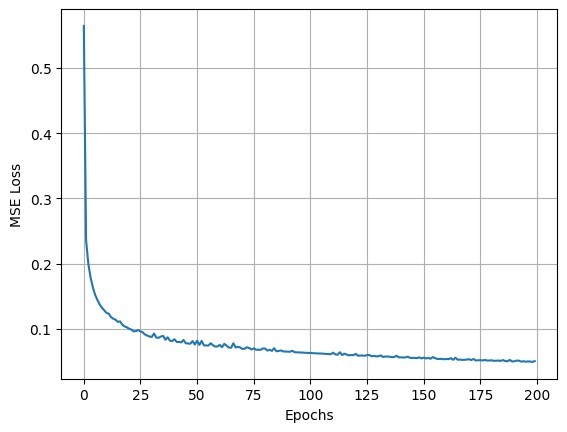

In [12]:
import matplotlib.pyplot as plt

plt.plot(augmented_simulator.train_losses)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

Then we can evaluate it on the test datasets of the benchmark. This is done by indicating the learned augmented simulator `augmented_simulator` as the argument of the `evaluate_simulator` method.

There are 2 steps performed within the evaluation of a simulator:
- Compute the prediction using the augmented simulator
- Evaluate the performances of the datasets within the benchmark with respect to the observation based on the prescribed metrics

In [12]:
fc_metrics = benchmark.evaluate_simulator(dataset="test", 
                                          augmented_simulator=augmented_simulator, 
                                          eval_batch_size=256000, 
                                          dtype=torch.float32,
                                          pin_memory=True,
                                          non_blocking=True,
                                          num_workers=16
                                          )

The result returned by this method contains all the metrics.

## Performance of an augmented simulator <a id="bench1-comp"></a>

### Machine learning metrics 

And now we can assess the performance of the "augmented simulator". If we want to retrieve the ML metrics on the test dataset we can use:

In [ ]:
ML_metrics = "ML"
dataset_name = "test"
print("Fully Connected Augmented Simulator")
print(f"Dataset : {dataset_name}")
print("{:<10} : {}".format("ML metrics", fc_metrics[dataset_name][ML_metrics]))

### Physic compliance
A trained augmented simulator could make some errors when verifying physics compliances.

In [ ]:
physic_compliances = "Physics"
dataset_name = "test"
physical_metrics = fc_metrics[dataset_name][physic_compliances]
print(physical_metrics)